In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys

import math
from datetime import datetime
from glob import glob
from datetime import timedelta
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
from igrf12py.igrf12fun import runigrf12, plotigrf 
%matplotlib inline
import requests
import os
import utils
import autoreload

In [99]:
# relative path to data dir
drifter_data_dir = 'data'
# I'm setting pretty conservative start/stop times based on plots of the data
base_drifter_dict = {
            'sneezy': {'type':'APS', 'id':66760, 'launch':'2012-08-26 00:00:00', 'end':'2012-10-12 00:00:00'}, 
            'bashful':{'type':'HMR', 'id':68740, 'launch':'2012-09-05 00:00:00', 'end':'2013-02-15 00:00:00'}, 
            'grumpy': {'type':'HMR', 'id':11070, 'launch':'2012-08-23 00:00:00', 'end':'2013-01-15 00:00:00'}, 
            'dopey':  {'type':'APS', 'id':68760, 'launch':'2012-09-15 00:00:00', 'end':'2013-01-01 00:00:00'}, 
             # sleepy looks like the z measurement is dominating the signal 
            'sleepy': {'type':'APS', 'id':19370, 'launch':'2012-09-01 00:00:00', 'end':'2013-06-01 00:00:00'}, 
            }



In [105]:
# load the txt files that we've created
reload(utils)
drifter_dict = utils.parse_txt_files(drifter_data_dir, base_drifter_dict)

Loading sneezy meas, cal, and list data files
Loading sleepy meas, cal, and list data files
Loading grumpy meas, cal, and list data files
Loading bashful meas, cal, and list data files
Loading dopey meas, cal, and list data files


In [189]:
sn = drifter_dict['sleepy']['cal']
print(sn.shape)
sn = sn.drop_duplicates( take_last=True)
print(sn.shape)

(81844, 35)
(65360, 35)


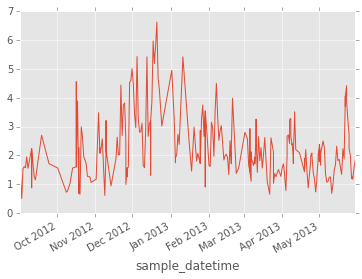

In [192]:
wv = sn.loc[sn['WVHT'] > 0]
# 99 is used as an invalid marker in the buoy dataset
wv = wv.loc[wv['WVHT'] < 99]
wv['WVHT'].plot()

('varh', 3728, 'varl', 1522)
('avg wvht high', 5.637142857142863, 'avg wavht low', 0.7405013280212502)


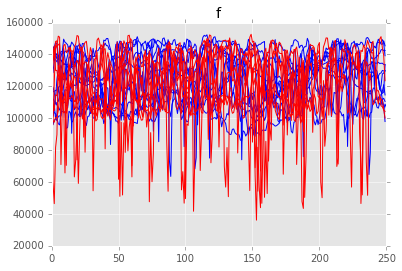

In [218]:
# the data below suggests that we see much less variance in the measurements on days in which 
# the wave height was low. 
# set the variable to compare here
column = 'f'

# scaler to make variance easier to look at. adjust as needed
db = 100000.

# set maximum wave height to consider low height
low_height = 1.
# set minimum height to consider
high_height = 5

# select only wave height under low_height
low = wv.loc[wv['WVHT'] < low_height]
# the dataframe is indexed by sample time, but we want a list of all samples in this cal routine, 
# so isolate based on cal_start time
sample_start_times = low['cal_start_datetime'].unique()
low_waves = []
plt.figure()
plt.title(column)
# keep track of sum of variances
vsl = 0
wave_l = 0
for ss in sample_start_times:
    # look at the sample_times from this calibration start time
    ll = low.loc[low['cal_start_datetime'] == ss]
    l = list(ll[column])
    # only use lists that have large calibration routines
    if len(l) > 190:
        vl = round(np.var(l),1)
        plt.plot(l, 'b')
        vsl += vl
        wave_l += np.mean(ll['WVHT'])
        low_waves.append(l)


high = wv.loc[wv['WVHT'] > high_height]
high = high.loc[high.index.unique()]
sample_start_times = high['cal_start_datetime'].unique()
high_waves = []
vsh = 0
wave_h = 0
for ss in sample_start_times:
    # look at the sample_times from this calibration start time
    hl = high.loc[high['cal_start_datetime'] == ss]
    h = list(hl[column])
    # only use lists that have large calibration routines
    if len(h) > 190:
        vh = round(np.var(h),1)
        vsh += vh
        plt.plot(h, 'r')
        high_waves.append(high)
        wave_h += np.mean(hl['WVHT'])
vsh = int((vsh/len(high_waves))/db)
vsl = int((vsl/len(low_waves))/db)
wave_h = wave_h/len(high_waves)
wave_l = wave_l/len(low_waves)
print('varh', vsh, 'varl', vsl)
print('avg wvht high', wave_h, 'avg wavht low', wave_l)


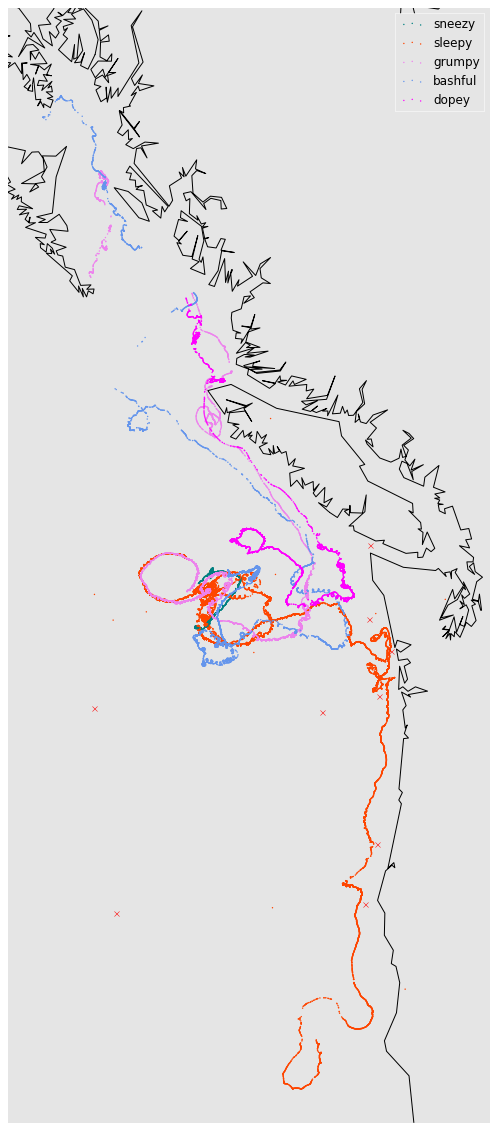

In [185]:
# Plot locations of the data
plt.figure(figsize=(20,20))
#build a map
m = Basemap(projection='merc', ellps='WGS84',
           llcrnrlat=39, 
           urcrnrlat=56, 
           llcrnrlon=-133,
           urcrnrlon=-122,
           resolution='l')

cc = ['teal', 'orangered', 'violet', 'cornflowerblue', 'magenta']
for nn, drifter in enumerate(drifter_dict.keys()):
    md = drifter_dict[drifter]['meas']
    x, y = m(np.array(md['lon']), np.array(md['lat']))
    m.scatter(x, y, c=cc[nn], edgecolor="None", s=2, label=drifter)
  
for bid in utils.buoy_list.keys():    
    latb, lonb = utils.buoy_list[bid]
    xb, yb = m(np.array(lonb), np.array(latb))
    m.scatter(xb, yb, s=26, c='r', marker='x')
    
m.drawcoastlines()
plt.legend()
plt.show()

In [254]:
# look at the calibration values
for nn in drifter_dict.keys():
#for nn in ['sleepy']:
    print(nn)
    
    dl = drifter_dict[nn]['list']
    dl.index = range(len(dl.index))
    #plt.figure(figsize=(20,7))
    for r in range(20):
        dx = dl.loc[r,'calsx']
        dffx = np.where(np.ediff1d(dx) < 100)

        dy = dl.loc[r,'calsy']
        dffy = np.where(np.ediff1d(dy) < 100)

        dz = dl.loc[r,'calsz']
        dffz = np.where(np.ediff1d(dz) < 100)
        #plt.plot(dffx, 'r')
        #plt.plot(dffy, 'b')
        #plt.plot(dffz, 'g')
    #plt.show()

sneezy
sleepy
grumpy
bashful
dopey


bashful


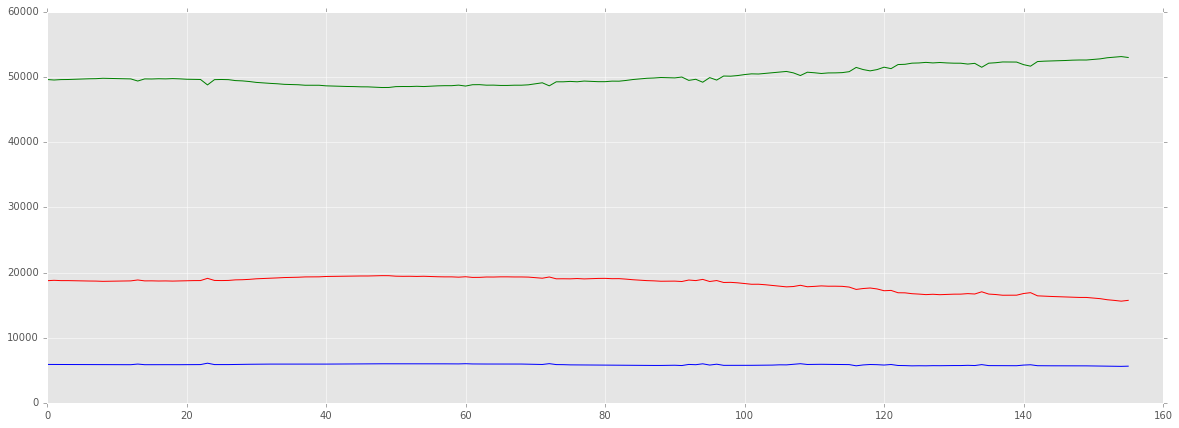

sleepy


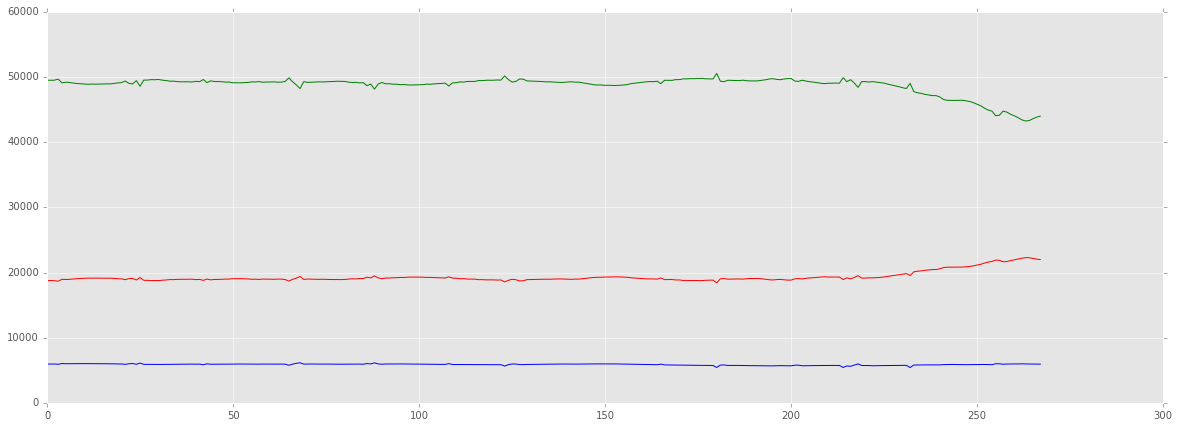

sneezy


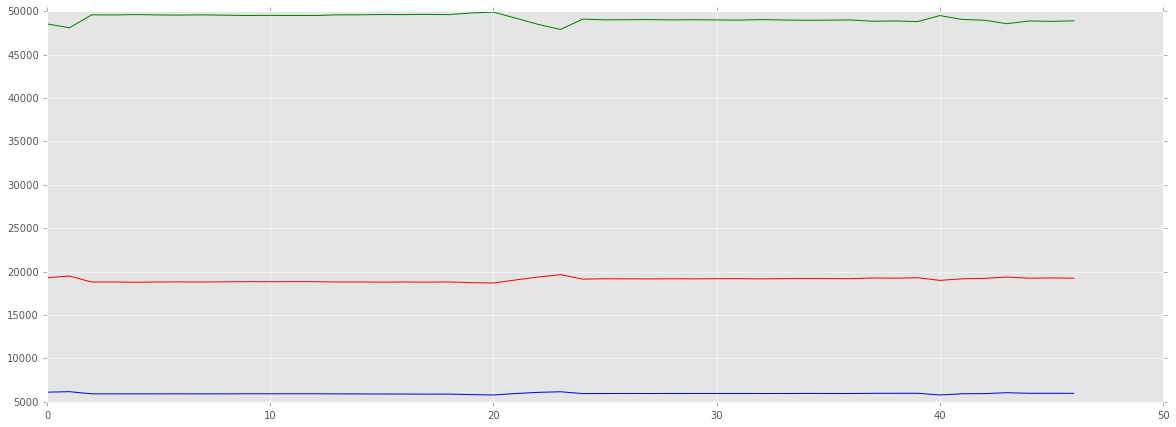

grumpy


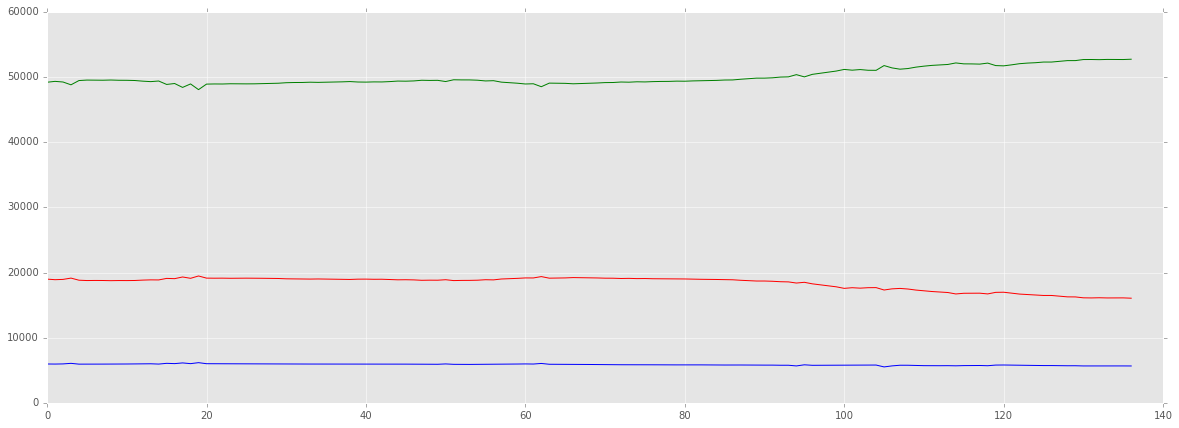

dopey


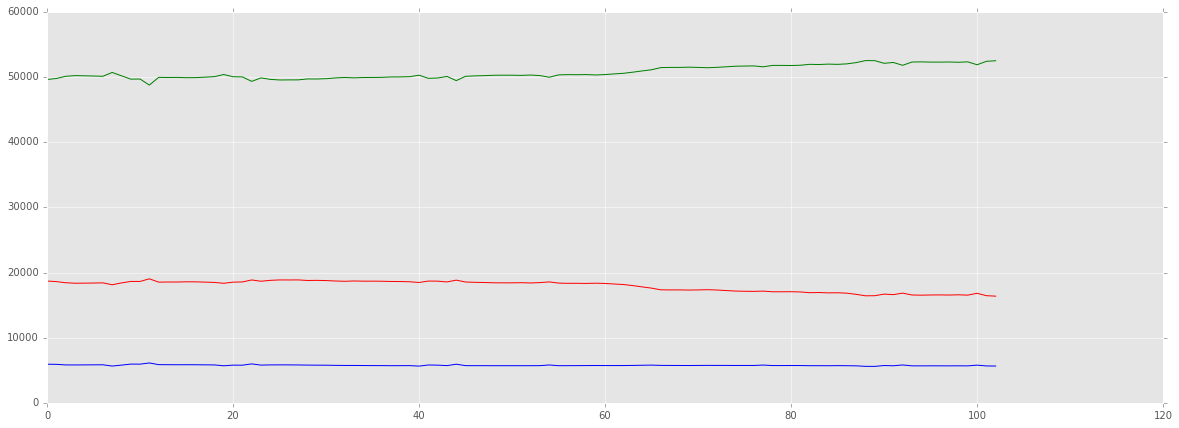

In [181]:
#look at the model values
for nn in drifter_dict.keys():
    print(nn)
    dl = drifter_dict[nn]['list']
    dl.index = range(len(dl.index))
    plt.figure(figsize=(20,7))
   
    plt.plot(dl['igrfx'], 'r')
    plt.plot(dl['igrfy'], 'b')
    plt.plot(dl['igrfz'], 'g')
    plt.show()



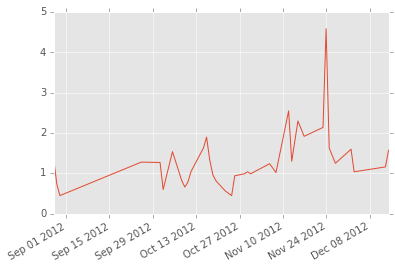

In [289]:
ss = ss[ss.loc[:,"WVHT"] != 99.00]
md = drifter_dict['grumpy']['list']
o = pd.merge(md, ss, left_index=True, right_index=True)
o['WVHT'].plot()